In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from dateutil import parser
from itertools import repeat
from collections import Counter, OrderedDict
import random

The purpose of this exercise is to better understand the March Madness tournament, with the goal of helping us to make better
decisions when filling out a tournament bracket and (hopefully!) helping us to win some of our co-workers' money. This notebook
is based _solely_ on seed matchup analysis. There is no modeling and minimal feature engineering involved. In another post
I may go into detail exploring the characteristics of underdogs-that-win vs favorites-that-lose, but for now I want to 
document in never-before-seen-detail the kinds of things to look for in terms of seed analysis that the average basketball
fan can use in upcoming tournaments. No understanding of machine learning necessary, and hopefully we can learn some cool
insights. I used exactly this analysis when I was filling out my 2019 bracket, and with my findings I was able to call 
Auburn making the Final Four ([only 3.9% of brackets saw this coming by the way](https://watchstadium.com/news/auburn-texas-tech-purdue-among-best-2019-ncaa-tournament-bracket-picks-03-31-2019/))
As we walk through this notebook I'll take you through my thought process as I was designing the bracket that won second place
in a pool of 100+ contestants, and first place in a pool of 60+.

First things first, I pulled historical NCAA data conveniently hosted on kaggle's website (apparently march madness is a topic ripe
with the attentions of fellow data scientists). I've popped the data file up on github so the avid readers can follow along if
inspiration strikes.

In [482]:
# I always start by taking a quick look at the data set
data = pd.read_csv('ncaa_data.csv')
data.head()

,Year,Round,Region Number,Region Name,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed
0,1985,1,1,West,1,83,St Johns,Southern,59,16,NaN
1,1985,1,1,West,2,81,VCU,Marshall,65,15,NaN
2,1985,1,1,West,3,65,NC State,Nevada,56,14,NaN
3,1985,1,1,West,4,85,UNLV,San Diego St,80,13,NaN
4,1985,1,1,West,5,58,Washington,Kentucky,65,12,NaN


I didn't get particularly fancy (and I would argue that you don't need to). I was able to get a high performing bracket
with minimal feature engineering. To start, let's create a column for "winning seed" so we can examine the distribution 
of winners per round. I'm also throwing out the 'Region Number' and 'Region Name' columns as they won't be useful to us.

In [397]:
data['winning_seed'] = np.where(data['score_1']>=data['score_2'], data['seed_1'], data['seed_2'])
data = data.drop(['Region Number', 'Region Name'], axis=1)
data.head()

,Year,Round,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed
0,1985,1,1,83,St Johns,Southern,59,16,1
1,1985,1,2,81,VCU,Marshall,65,15,2
2,1985,1,3,65,NC State,Nevada,56,14,3
3,1985,1,4,85,UNLV,San Diego St,80,13,4
4,1985,1,5,58,Washington,Kentucky,65,12,12


Let's also create an 'upset' column to tell us whether or not a given game
went "as expected"

In [398]:
data['favorite'] = np.where(data['seed_1']<data['seed_2'], data['seed_1'], data['seed_2'])
data['underdog'] = np.where(data['seed_1']<data['seed_2'], data['seed_2'], data['seed_1'])
# account for cases where there is no favorite (ie identical seeds)
data['favorite'] = np.where(data['seed_1'] == data['seed_2'], -1, data['favorite'])
data['underdog'] = np.where(data['seed_1'] == data['seed_2'], -1, data['underdog'])
data['upset'] = np.where(data['winning_seed'] != data['favorite'], 1, 0)
# force games showcasing tied seeds to be '0' in the 'upset' column
data['upset'] = np.where(data['favorite'] == -1, 0, data['upset'])
data.head()

,Year,Round,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed,favorite,underdog,upset
0,1985,1,1,83,St Johns,Southern,59,16,1,1,16,0
1,1985,1,2,81,VCU,Marshall,65,15,2,2,15,0
2,1985,1,3,65,NC State,Nevada,56,14,3,3,14,0
3,1985,1,4,85,UNLV,San Diego St,80,13,4,4,13,0
4,1985,1,5,58,Washington,Kentucky,65,12,12,5,12,1


The million dollar question when filling out a bracket is, _"to upset, or not to upset?"_ The naive bracket would simply select
higher seeds to defeat lower seeds and result in the number 1 overall seed clinching the title. We can do better. To 
start, the first question I asked is, how common are upsets at different stages of the tournament? Also worth noting is that 
this is a  comprehensive data set spanning back to the beginning of this age old tradition, [1985](https://genius.com/Bowling-for-soup-1985-lyrics)
I assumed that modern day hoops are a different beast from the game during the time of the 45 second [shot clock](https://www.vuhoops.com/2010/07/27/cats-owls-and-the-story-of-the-shot-clock),
so I chose to consider the 16 most recent tournaments from 2003 onward.


In [399]:
data = data.query('Year >= 2003')
data[['upset', 'Round']].groupby(['Round']).agg('sum')

,upset
Round,
1,130
2,74
3,37
4,33
5,6
6,3


It looks like there have been three finals upsets in the 16 year period since 2003. How many games had _upset potential_ during this period?

To answer this, we can't just simply count games by round. Remember, we only want to count games where an upset was _possible_. So we
should really be excluding all rows where favorite = -1 (recall our definition of this earlier, it simply means the game 
showcased two teams of the same seed, so there was no possibility that an upset could even occur).

In [400]:
data.query('favorite != -1')[['upset', 'Round']].groupby(['Round']).agg('count')

,upset
Round,
1,512
2,256
3,128
4,64
5,24
6,11


In [401]:
# includes games without upset potential
data[['upset', 'Round']].groupby(['Round']).agg('count')

,upset
Round,
1,512
2,256
3,128
4,64
5,32
6,16


It looks like there have been 5 finals since 2003 showcasing tied seeds, and 12 final fours showcasing tied seeds. This makes
sense! Given the structure of the tournament it would be impossible for a game to feature tied seeds in any of the first four rounds. We'll want
to exclude these "tied seed" games from our 'upset percentage' analysis, since we want to pose the question, "Given that an upset _is possible_, how likely is it to occur", and not "how likely is an upset to occur?" It's a subtle difference, but the
distinction could mean the difference between glorious victory and office shame.  

Now that we've excluded games featuring tied seeds, we can merge _actual upsets_ with candidate upset
matches. There is probably a more pythonic way to do this, I am currently accepting pull requests :)

In [402]:
# Since 2003
all_potentially_upset_games = data.query('favorite != -1')[['upset', 'Round']].groupby(['Round']).agg('count')
all_upsets = data[['upset', 'Round']].groupby(['Round']).agg('sum')
upset_pct = pd.concat([all_potentially_upset_games, all_upsets], axis=1, ignore_index=True)
upset_pct = upset_pct.rename(columns = {0: "upset_candidates", 
                                  1:"actual_upsets" 
                                  })
upset_pct['upset_pct'] = upset_pct['actual_upsets']/upset_pct['upset_candidates']
upset_pct

,upset_candidates,actual_upsets,upset_pct
Round,,,
1,512,130,0.253906
2,256,74,0.289062
3,128,37,0.289062
4,64,33,0.515625
5,24,6,0.250000
6,11,3,0.272727


Well what do we have here? Honestly, I would have expected to see more upsets early on and fewer upsets later on in the 
tournament. Shockingly though, historical upset rates are pretty constant, hovering around the 25% mark. But in the elite eight
(round 5) that stat essentially doubles to 50% ! This is an important observation for those of us working on filling out a 
bracket --it means that we may want to think about choosing a few extra upsets in the elite eight. Side note, this year Duke, 
Gonzaga, and Kentucky all sufferred elite eight losses (75% of games resulted in upsets.) Seems like a pretty powerful insight 
to me!

The next thing I want to look at is a distribution of winning seeds by round. It's all well and good to be looking at upset
rates, but our task is to select _the right_ upsets. So we have to be smart about where we lay down our cards.

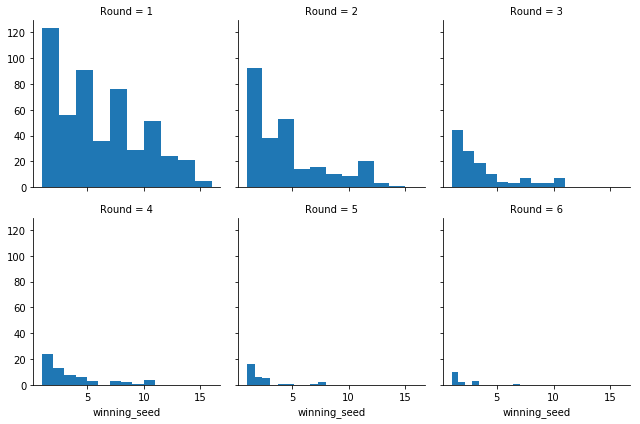

In [403]:
g = sn.FacetGrid(data, col="Round", col_wrap = 3)
g.map(plt.hist, "winning_seed");

Let's take a second to understand what we're looking at here. We have a nice distribution broken out by round looking
at winning seeds throughout the tournament. In the finals specifically, we can see that 3 seeds have bested a 2-seed twice,
and a 2 seed overthrew a mighty 1-seed once in 2016. I'd like to see a heatmap informing _which_ upset matchups are the 
most common (how likely is a 13 seed to displace a 4 seed vs a 5 seed over a 4 seed for example?) Luckily seaborn has a 
nice heatmap functionality we can take advantage of in order to visualize this.

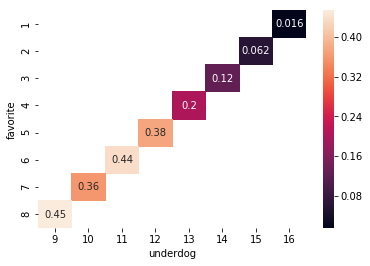

In [405]:
# Let's focus on Round 1
favs = [1, 2, 3, 4, 5, 6, 7, 8]
underdogs = [16, 15, 14, 13, 12, 11, 10, 9]
upset_rate = []
occurences = []
round1 = data.query('Round == 1')
for i in range(1,9):
    matchups = round1[round1['favorite'] == i].shape[0]
    upsets = round1[round1['favorite'] == i][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))

round1_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

upsets = round1_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(upsets, annot=True,)

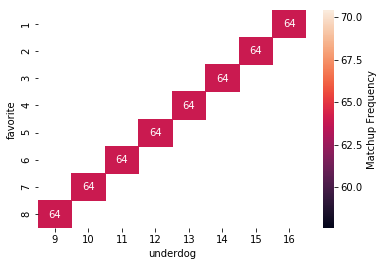

In [417]:
# Plot of matchup frequency as a sanity check to verify that each of the 16 initial round matchups occur exactly 64 times
# In our 16 year data set where each matchup occurs 4 times per year, we expect to see each 64 occurrences for each
# I like to QA my analysis throughout the process to make sure I'm actually doing what I think I am 
freq = round1_upsets.pivot("favorite", "underdog", "occurences")
ax = sn.heatmap(freq, annot=True, cbar_kws={'label': 'Matchup Frequency'})

In Round 1, it might not be a bad idea to pick your favorite 13 seed to displace a 4 seed (13s win 20% of the time.) 
I would advise just advancing all 1, 2, and 3 seeds through to the round of 32. Spend time choosing likely upsets in the
8 v 9, 7 v 10, 6 v 11, and 5 v 12 realm. If this notebook is popular, I'll write something up about how to detect signals
that would indicate whether a team has a good chance of upsetting an opponent. For this post, we're just looking at how
_many_ of these upsets we want to forecast, and during which rounds and for which matchups we should forecast them. 
We'll talk about how to select from eligible upsets in another post, but the key takeaway from this data is that the best 
"bang for your buck" upset pick is 9 v 8, 
followed closely by 11 v 6.

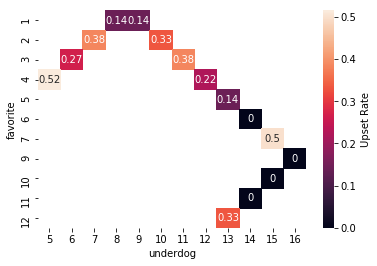

In [414]:
# What about round 2?
round2 = data.query('Round == 2')

favorites = list(set(round2['favorite']))
favs = []
underdogs = []

for fav in favorites:
    dogs = list(set(round2[round2['favorite'] == fav]['underdog']))
    favs.extend(repeat(fav, len(dogs)))
    underdogs.extend(dogs)



upset_rate = []
occurences = []
for i in range(0, len(favs)):
    
    matchups = round2[(round2.favorite == favs[i]) & (round2.underdog == underdogs[i])].shape[0]
    upsets = round2[(round2.favorite == favs[i]) & (round2.underdog == underdogs[i])][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))


    
round2_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round2_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True, cbar_kws={'label': 'Upset Rate'})

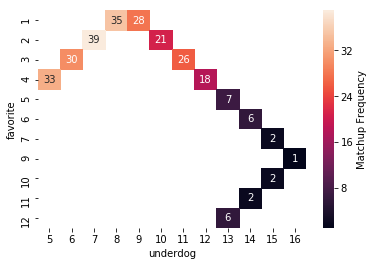

In [415]:
heat = round2_upsets.pivot("favorite", "underdog", "occurences")
ax = sn.heatmap(heat, annot=True, cbar_kws={'label': 'Matchup Frequency'})

Often when I'm filling out a bracket I get overwhelmed by the amount of reserach I'd need to do to call each game sensically.
Usually I start out with lots of enthusiasm, quickly get overwhelmed, and then somewhat carelessly fill it out for completion
rather than accuracy. This system offers a unique perspective on where to spend your resources. Not only can we visualize
upset rates for each potential combination of seeds, we can also visualize the _frequency_ that each combination occurs.
For example, if we were just looking at upset_rate, we would see that 15 seeds beat 7 seeds 50% of the time. But our
frequency map tells us that this combination has only occurred twice in 16 years. This means that we can't be too confident
in our 50% estimate of the upset rate since our sample size is quite small.

Notice that in Round 2 a favorite can face underdogs of various seeds. That is, if we consider 4 seeds for a moment we can see
that they lose to 5 seeds 52% of the time, but only lose to 12 seeds 22% of the time. I chose to break out the different
ways a favorite could be matched up against an underdog to extract exactly this distinction. If I had simply calculated
a 4 seed's upset rate as the count of all the times they had been upset divided by the count of all the times they had made
the second round, I would lose information about how their likelihood of being upset changes depending on the seed they face.

Before moving on to the sweet sixteen there are a few interesting observations I'd like to point out. First, a 1 v 9 upset is equally as
likely as a 1 v 8 upset (14%). Not altogether surprising, but interesting to see identical upset rates given that both matchups
have occurred relatively frequently over the past 16 years. Also interesting to note that 3 seeds are more likely to be 
upset by 11 seeds than 6 seeds!  (38% vs 27%)! Lastly, in the 33 occurences
where a 4 seed has played a 5 seed, 5 seeds actually win slightly more often (52%). The most commonly occuring matchup in 
Round 2 is a 2 v 7 showdown, and 7's take the cake 38% of the time. These are some interesting insights! Let's see what 
we can learn from the sweet sixteen.

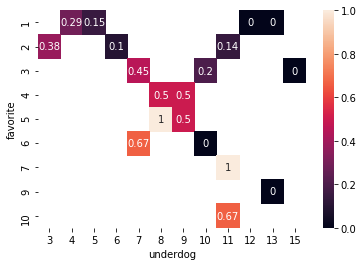

In [311]:
# What about round 3?
round3 = data.query('Round == 3')

favorites = list(set(round3['favorite']))
favs = []
underdogs = []

for fav in favorites:
    dogs = list(set(round3[round3['favorite'] == fav]['underdog']))
    favs.extend(repeat(fav, len(dogs)))
    underdogs.extend(dogs)



upset_rate = []
occurences = []
for i in range(0, len(favs)):
    
    matchups = round3[(round3.favorite == favs[i]) & (round3.underdog == underdogs[i])].shape[0]
    upsets = round3[(round3.favorite == favs[i]) & (round3.underdog == underdogs[i])][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))


    
round3_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round3_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,)

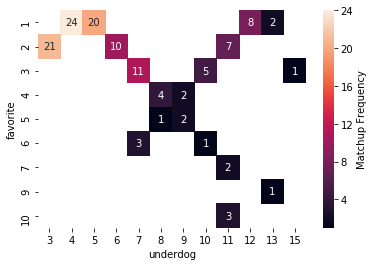

In [421]:
heat = round3_upsets.pivot("favorite", "underdog", "occurences")
ax = sn.heatmap(heat, annot=True, cbar_kws={'label': 'Matchup Frequency'})

We're starting to see some data paucity problems in this realm, as our sample size quickly pares down. So we need to be
careful about the inferences we make, especially in cases where seed matchups have occurred only a handful of times in 
history. There are countless factors that can influence upset outcomes, so of course a strictly-seed-based analysis is
a gross oversimplification of the problem. The goal here is just to extract all that we can out of the seed information
at hand. One thing that jumps out at me here is the 3 v 7 matchup -- 7 seeds advance to the Elite Eight 45% of the time.
And about 1 out of 4 times a 4 seed defeats a 1 seed. The coincidental symmetry there is pleasing, is it not? Let's get
into the elite eight and see what we can find.

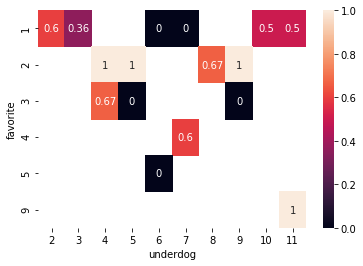

In [346]:
# What about round 4?
round4 = data.query('Round == 4')

favorites = list(set(round4['favorite']))
favs = []
underdogs = []

for fav in favorites:
    dogs = list(set(round4[round4['favorite'] == fav]['underdog']))
    favs.extend(repeat(fav, len(dogs)))
    underdogs.extend(dogs)



upset_rate = []
occurences = []
for i in range(0, len(favs)):
    
    matchups = round4[(round4.favorite == favs[i]) & (round4.underdog == underdogs[i])].shape[0]
    upsets = round4[(round4.favorite == favs[i]) & (round4.underdog == underdogs[i])][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))


    
round4_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round4_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,)

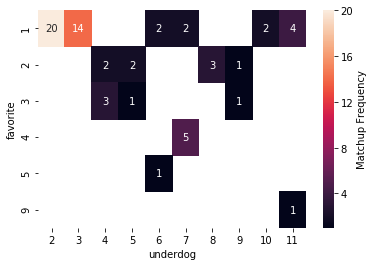

In [424]:
heat = round4_upsets.pivot("favorite", "underdog", "occurences")
ax = sn.heatmap(heat, annot=True, cbar_kws={'label': 'Matchup Frequency'})

In [ ]:
The first thing that jumped out at me here at the 1 seeds that lost to 11 and 10 seeds in the elite eight. That is crazy!
Before I did anything else I had to see who played in those games.

In [426]:
round4.query('seed_1 == 1 & (seed_2 == 11 | seed_2 == 10)')

,Year,Round,Region Number,Region Name,seed_1,score_1,team_1,team_2,score_2,seed_2,winning_seed,favorite,underdog,upset
1381,2006,4,3,East,1,84,Connecticut,George Mason,86,11,11,1,11,1
1506,2008,4,2,Midwest,1,59,Kansas,Davidson,57,10,1,1,10,0
1696,2011,4,3,Southwest,1,61,Kansas,VCU,71,11,11,1,11,1
1883,2014,4,1,South,1,62,Florida,Dayton,52,11,1,1,11,0
2012,2016,4,4,Midwest,1,62,Virginia,Syracuse,68,10,10,1,10,1
2073,2017,4,2,West,1,83,Gonzaga,Xavier,59,11,1,1,11,0


Looks like Syracurse toppled Virginia in 2016 (man the Cavaliers have had it [rough from lowly seeded teams](https://en.wikipedia.org/wiki/2018_UMBC_vs._Virginia_men%27s_basketball_game)),
VCU toppled Kansas in 2011, and George Mason bested UCONN in 2006. Now you can impress your friends with all these forgotten
NCAA facts. Ok on to more analysis.

The elite eight is the magic round with over 50% of upset candidates resulting in actual upsets. If you recall from our preliminary EDA,
each round held roughly a 25% average upset rate _except for the elite eight_, which saw a wild jump to over 50% of games
resulting in actual upsets. For good measure we can remind ourselves of this fact:

In [427]:
upset_pct

,upset_candidates,actual_upsets,upset_pct
Round,,,
1,512,130,0.253906
2,256,74,0.289062
3,128,37,0.289062
4,64,33,0.515625
5,24,6,0.250000
6,11,3,0.272727


Let's pause for a moment and do a quick bit of QA to make sure this anaysis hasn't gone rogue without me realizing it (I mean that has
_never_ happened to me before so it's almost not even worth checking, but we'll do it anyway).

In [429]:
# very that round4 has 33 upsets as shown initiallyS
sum(round4['upset'])

33

I was really curious to see what story
the data would tell us here. Interestingly, nearly half of the total upsets happened from 2 seeds taking down 1 seeds. Very interesting! Also
interesting to see that 3 seeds have taken down 1 seeds in 5 out of 14 matchups. Hmmm, it seems like 1 seeds are falling more often
than other seeds. I wonder, are 1 seeds more vulnerable to
upsets than other seeds? Maybe the pressure gets to them? Or are we just seeing lots of upsets against 1 seeds since 1 seeds
should be statistically the most likely to make it this far and therefore they _have the ability_ to be upset more than lower seeds.
A simple way to answer this would just be to sum the upsets by favorite and sum the occurences by favorite and look at the
upset percentage _by seed_ in the elite eight. The null hypothesis being that there is no statistically significant
difference between upset rates across seeds.

In [355]:
seed_vulnerability = round4_upsets[['favorite', 'occurences', 'upset_count']].groupby(['favorite']).agg('sum')
seed_vulnerability['vulnerability'] = seed_vulnerability['upset_count']/seed_vulnerability['occurences']
seed_vulnerability

,occurences,upset_count,vulnerability
favorite,,,
1,44.0,20.0,0.454545
2,8.0,7.0,0.875000
3,5.0,2.0,0.400000
4,5.0,3.0,0.600000
5,1.0,0.0,0.000000
9,1.0,1.0,1.000000


Interesting, from this perspective it actually seems that 1 seeds aren't totally tanking in the elite eight. Two seeds
on the other hand, when playing as a favorite, have a rough time here! It looks like when 2 seeds are a favorite to win an elite eight game,
_they lose 87.5% of the time._ That is absurd to me! 1 seeds lose 45% of the time, so it seems like the 1 seeds might
be slightly better at handling the pressure than their lowly 2-seeded-counterparts. 5 seeds are _undefeated_ in the elite
eight when going into the matchup a favorite (over a 6 seed, one time in history.) Still an interesting thing to note
though. If anyone is still with me in this absurdly in depth seed analysis, I applaud you, and I thank you kindly. Let's
move onwards to some final four findings.

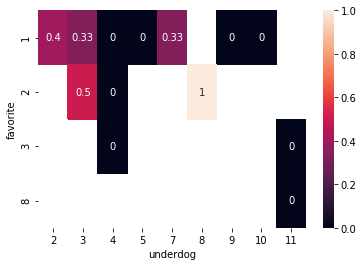

In [317]:
# What about round 5?
round5 = data.query('Round == 5')

favorites = list(set(round5['favorite']))
favs = []
underdogs = []

for fav in favorites:
    dogs = list(set(round5[round5['favorite'] == fav]['underdog']))
    favs.extend(repeat(fav, len(dogs)))
    underdogs.extend(dogs)



upset_rate = []
occurences = []
for i in range(0, len(favs)):
    
    matchups = round5[(round5.favorite == favs[i]) & (round5.underdog == underdogs[i])].shape[0]
    upsets = round5[(round5.favorite == favs[i]) & (round5.underdog == underdogs[i])][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))


    
round5_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round5_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,)

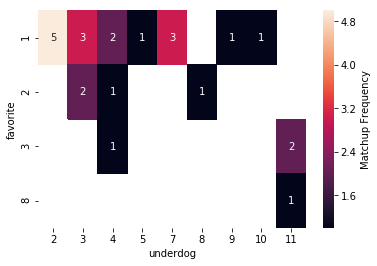

In [431]:
heat = round5_upsets.pivot("favorite", "underdog", "occurences")
ax = sn.heatmap(heat, annot=True, cbar_kws={'label': 'Matchup Frequency'})

Picking the two finals team, if nothing else, can get one _very_ far in this tournament. Find out how many people predicted this year's championship game [here](https://www.ncaa.com/news/basketball-men/article/2019-04-08/only-03-percent-people-picked-championship-game-heres-who).
Hint: it's not a lot. Understanding how upsets tend to play out in the final four can help you decide which teams make it 
out of the final four and into the final round of the Big Dance.

Text(0.5, 1.0, 'Historical Distribution of Final Four Seeds')

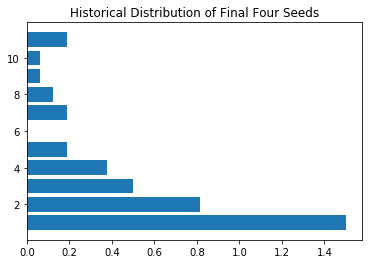

In [467]:
final_four_dist = {}
years = list(set(round5['Year']))

# obtain a dictionary keyed on year with a list of the four seeds that appeared in the final four that year
for year in years:
    final_four_dist[year] = list(round5[round5['Year'] == year]['seed_1'])+list(round5[round5['Year'] == year]['seed_2'])

# get an average appearance by seeds that have been in the final four over the past 16 years

# get a list of unique seeds
seed1s = list(round5['seed_1'])
seed2s = list(round5['seed_2'])
all_seeds = seed1s + seed2s

seed_frequency = dict(Counter(all_seeds))

for key, value in seed_frequency.items():
    seed_frequency[key] = seed_frequency[key]/16

# verify that the expected number of teams equals 4
sum(seed_frequency.values())

plt.barh(list(seed_frequency.keys()), list(seed_frequency.values()))
plt.title('Historical Distribution of Final Four Seeds')

In [442]:
# dividing the total number of final four appearances by the total number of final fours (16) gives us an expectation
# for the number of each seed in a given final four
# interperet this as, we'd expect a 3 seed to feature in a final four every other year
# in any two final fours there will be about 3 1-seeds
# we'd expect a 5 seed to make the final four about once every 5 years
# etc etc etc
seed_frequency

{3: 0.5,
 1: 1.5,
 4: 0.375,
 11: 0.1875,
 2: 0.8125,
 5: 0.1875,
 7: 0.1875,
 8: 0.125,
 9: 0.0625,
 10: 0.0625}

In [ ]:
One thing to note about this is that our sample size is statistically tiny. So there is likely to be lots of variability
in our _actual_ vs _expected_ seed distributions in the final four. Especiallly given that most seeds have an expectation of less
than one to appear in a given final four, this distribution is likely to fall apart if we try to apply it to any one 
specific example. Let's test this by taking 5 samples from our distribution of final four seeds and see what happens.

How does our sample distribution align with our historical distribution?

Text(0.5, 1.0, 'Sample Distribution x5')

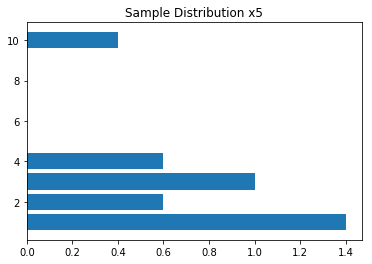

In [478]:
sample_seeds = random.sample(all_seeds, 4) + random.sample(all_seeds, 4) + random.sample(all_seeds, 4) + random.sample(all_seeds, 4) + random.sample(all_seeds, 4)
sample_seeds = dict(Counter(sample_seeds))

for key, value in sample_seeds.items():
    sample_seeds[key] = sample_seeds[key]/5

# verify that the expected number of teams equals 4
sum(sample_seeds.values())

plt.barh(list(sample_seeds.keys()), list(sample_seeds.values()))
plt.title('Sample Distribution x5')

Text(0.5, 1.0, 'Sample Distribution x5')

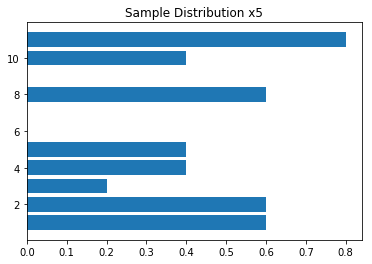

In [479]:
sample_seeds = random.sample(all_seeds, 4) + random.sample(all_seeds, 4) + random.sample(all_seeds, 4) + random.sample(all_seeds, 4) + random.sample(all_seeds, 4)
sample_seeds = dict(Counter(sample_seeds))

for key, value in sample_seeds.items():
    sample_seeds[key] = sample_seeds[key]/5

# verify that the expected number of teams equals 4
sum(sample_seeds.values())

plt.barh(list(sample_seeds.keys()), list(sample_seeds.values()))
plt.title('Sample Distribution x5')

With 5 samples our distribution looks completely different from what we'd expect to see historically. But the historical distribution
should tend to hold true if we take many different samples. What this essentially means is, if you assume this historical
distribution will hold over _many samples_, then you should select final four teams based on this distribution _every year_. On
average, your predictions will align with reality _more often_ than if you selected final four teams at random.

Text(0.5, 1.0, 'Sample Distribution x5')

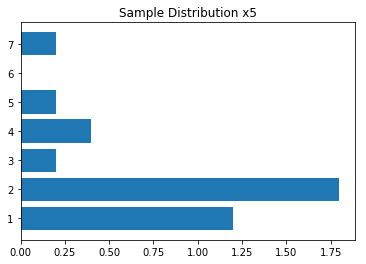

In [480]:
sample_seeds = random.sample(all_seeds, 4) + random.sample(all_seeds, 4) + random.sample(all_seeds, 4) + random.sample(all_seeds, 4) + random.sample(all_seeds, 4)
sample_seeds = dict(Counter(sample_seeds))

for key, value in sample_seeds.items():
    sample_seeds[key] = sample_seeds[key]/5

# verify that the expected number of teams equals 4
sum(sample_seeds.values())

plt.barh(list(sample_seeds.keys()), list(sample_seeds.values()))
plt.title('Sample Distribution x5')

Text(0.5, 1.0, 'Sample Distribution, x1000')

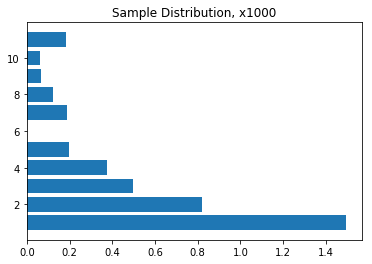

In [477]:
sample_seeds = []
samples = 10000
for i in range(1,samples):
    sample_seeds.extend(random.sample(all_seeds, 4))
    
sample_seeds = dict(Counter(sample_seeds))

for key, value in sample_seeds.items():
    sample_seeds[key] = sample_seeds[key]/samples

# verify that the expected number of teams equals 4
sum(sample_seeds.values())

plt.barh(list(sample_seeds.keys()), list(sample_seeds.values()))
plt.title('Sample Distribution, x1000')

Text(0.5, 1.0, 'Historical Distribution of Final Four Seeds')

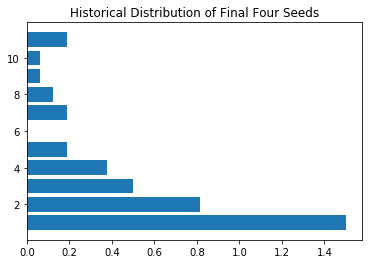

In [473]:
plt.barh(list(seed_frequency.keys()), list(seed_frequency.values()))
plt.title('Historical Distribution of Final Four Seeds')

That was a pretty unnecessary aside into resampling methods to be honest. But I this property interesting. Let's get on with
our analysis of the final four.

In [448]:
# historical distribution of final four teams
final_four_dist

{2016: [2, 1, 2, 10],
 2017: [7, 3, 1, 1],
 2018: [11, 1, 3, 1],
 2003: [3, 1, 2, 3],
 2004: [3, 1, 2, 2],
 2005: [1, 1, 4, 5],
 2006: [4, 11, 2, 3],
 2007: [1, 2, 2, 1],
 2008: [1, 1, 1, 1],
 2009: [2, 3, 1, 1],
 2010: [5, 2, 5, 1],
 2011: [4, 11, 3, 8],
 2012: [1, 2, 4, 2],
 2013: [1, 4, 9, 4],
 2014: [1, 2, 7, 8],
 2015: [1, 7, 1, 1]}

This was a surprising distribution. I hadn't realized how highly skewed the final four is to 1, 2 and 3 seeds. If your 
bracket does nothing but predict the final four correctly you could find yourself a [champion of your office pool](https://www.ncaa.com/news/basketball-men/article/2019-04-01/only-02-percent-people-correctly-predicted-2019-final-four). 
Understanding how seeds tend to be distributed in this round can help you eliminate teams from the selection process. 
My takeaway from this graph is to have no more than 2 1 seeds in the final four. Choose a 2 seed or a 3 seed you feel 
confident in. For your last final four candidate, go with your gut or create your own signals for predicting likelihood
of advancement. This year fans were _shocked_ when Auburn made it to the final four (apparently only [3.9% of brackets forsaw that one](https://watchstadium.com/news/auburn-texas-tech-purdue-among-best-2019-ncaa-tournament-bracket-picks-03-31-2019/)) but really, 1 in 5 final fours
Spoiler alert: mine was one of them. But given this data, final fours feature a five seed about once every five years. 
I would recommend picking your final four before you fill out any other portion of your bracket. My logic
for building my 2019 bracket went as follows: First you need to rank order the 4 one seeds from best to worst. There are
so many methods for doing this but honestly this is where the beauty of bracketology comes into play. I'd recommend watching
some highlight videos to get to know the teams. Read up on the coaches, players, the school history. Go with your gut.
At the end of the day, you want to be happy when your team goes all the way. As a wise old owl once said, go with your heart,
not your head. Anyways, I chose Gonzaga and Virgina, mostly because I hate wanted Duke to lose and UNC looked weak to me
on film. Again, mostly a judgement call softly influenced by data. Next, since I'd already decided that Duke and UNC would
lose, I had to pin down which lucky team would beat them. For Duke, I chose MSU since no other team in the East seemed
good enough to take down Zion, and MSU looked filthy on film. For UNC, advanced them to the sweet sixteen (given
what we learned from our Round 1 & 2 analysis). Round 3's analysis showed that a 1 seed has lost to a 5 seed exactly 3
times over the past 16 years, or in 15% of 1 v 5 matchups. After watching some film of Auburn and UNC, I decided that the
Tigers had what it took to overtake the Tar Heels. Definitely went out on a limb, but that's how I built my final four
with 3 out of the 4 final four teams. In another post we can discuss things to look for that convinced me Auburn could
make it, but hey, this all could have just been dumb luck anyway. 

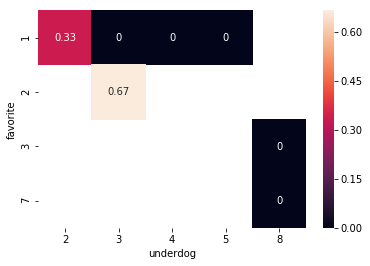

In [322]:
# What about round 6?
round6 = data.query('Round == 6')

favorites = list(set(round6['favorite']))
favs = []
underdogs = []

for fav in favorites:
    dogs = list(set(round6[round6['favorite'] == fav]['underdog']))
    favs.extend(repeat(fav, len(dogs)))
    underdogs.extend(dogs)



upset_rate = []
occurences = []
for i in range(0, len(favs)):
    
    matchups = round6[(round6.favorite == favs[i]) & (round6.underdog == underdogs[i])].shape[0]
    upsets = round6[(round6.favorite == favs[i]) & (round6.underdog == underdogs[i])][['upset']].agg('sum')
    upset_rate.append(float(upsets/matchups))
    occurences.append(float(matchups))


    
round6_upsets = pd.DataFrame(
    {'favorite': favs,
     'underdog': underdogs,
     'upset_rate': upset_rate,
     'occurences': occurences
    })

heat = round6_upsets.pivot("favorite", "underdog", "upset_rate")
ax = sn.heatmap(heat, annot=True,)

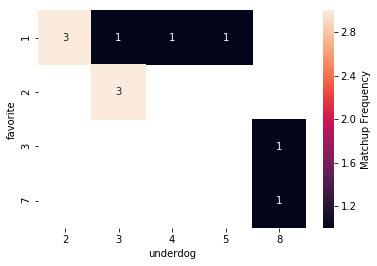

In [474]:
heat = round6_upsets.pivot("favorite", "underdog", "occurences")
ax = sn.heatmap(heat, annot=True, cbar_kws={'label': 'Matchup Frequency'})

<BarContainer object of 7 artists>

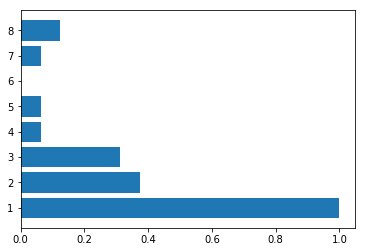

In [385]:
finals_dist = {}
years = list(set(round6['Year']))

# obtain a dictionary keyed on year with a list of the four seeds that appeared in the final four that year
for year in years:
    finals_dist[year] = list(round6[round6['Year'] == year]['seed_1'])

# get an average appearance by seeds that have been in the final four over the past 16 years

# get a list of unique seeds
seed1s = list(round6['seed_1'])
seed2s = list(round6['seed_2'])
all_seeds = seed1s + seed2s

seed_frequency = dict(Counter(all_seeds))

for key, value in seed_frequency.items():
    seed_frequency[key] = seed_frequency[key]/16

# verify that the expected number of teams equals 4
sum(seed_frequency.values())

plt.barh(list(seed_frequency.keys()), list(seed_frequency.values()))

In [389]:
seed_frequency

{2: 0.375, 3: 0.3125, 1: 1.0, 5: 0.0625, 7: 0.0625, 8: 0.125, 4: 0.0625}

On average we can expect there to be at least one 1 seed in the finals. But there is more likely to be only 1 than two 1 
seeds. So when filling out your bracket if you pick two one seeds, you increase your odds of getting at least one finals
team, but you decrease your odds of getting both right. Again, I would recommend you think carefully about the two 1 seeds
you send to the final four and really commit to one or the other, not both. To pick your second finalist, it's more or less
a toss up between 2 and 3 seeds, they make finals appearances about equally as often. I had Virginia at MSU in my finals,
so this method definitely isn't foolproof. But this is generally the method I would use to build your bracket. Here is my
last key piece of advice, once you've filled out your bracket, count up how many upsets you've called. Is your distribution
similar to what we've seen historically? The distributions in this analysis will tell you how likely each of the upsets 
(or not upsets) you've called are to happen (or not happen). Go through game by game and sanity check yourself to see if
you're being too conservative or too trigger happy. I think I ended up advancing Auburn because I didn't have enough upsets,
and I also didn't want to end up with a Final Four comprised of two 2-seeds and two 1-seeds. Because that's just boring.
At the end of the day, bracket games are meant to be fun. Granted, it's always fun to take the glory but who knows how
well this method will fare for me next year. All I know is it did amazingly well for me this year, so it seemed prudent
to document my methodologies and share with the like minded. If you've made it this far, wow. You're truly a champion.
Enjoy some pretty plots that I made. The rest of this notebook is just scribble scrabble that I don't want to delete
because maybe I'll use it at some point! Hoarding code isn't a thing. Or is it?

In [ ]:
# Appendix Stuff Below, Can Ignore

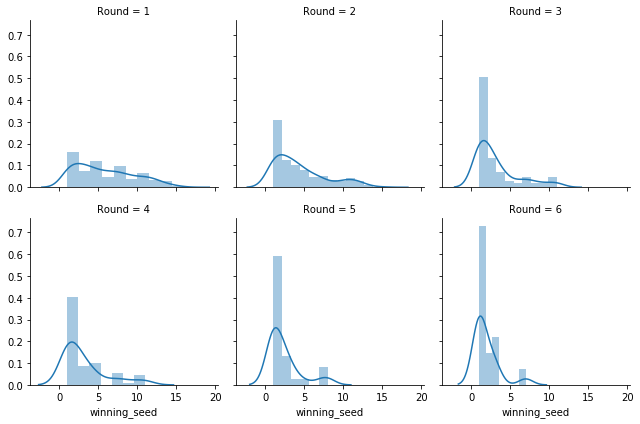

In [78]:
g = sn.FacetGrid(data, col="Round", col_wrap = 3)
g.map(sn.distplot, "winning_seed");

In [475]:
# compute mean of upset statistic
data.query('Year >= 2003 & favorite != -1')[['upset', 'Year']].groupby(['Year']).agg('sum')['upset'].mean()

17.6875

So what do we know so far? Well in this preliminary EDA we've shown that the most recent trend in the march madness tournament
shows an interesting trend where elite eight upsets are statistically more probable than in any other round of the tournament.
I'm going to hard code in the upset rates for this year's tournament to see how the historical trend matched up this year

In [57]:
# 2019 data manually loaded
rounds = [1,2,3,4,5,6]
upset_candidates = [32, 16, 8, 4, 2, 1]
actual_upsets = [12, 1, 3, 3, 1, 0]
bracket_2019 = pd.DataFrame(
    {'rounds': rounds,
     'upset_candidates': upset_candidates,
     'actual_upsets': actual_upsets,
     'historical_upset_pct': upset_pct['upset_pct']
    })
bracket_2019['upset_pct'] = bracket_2019['actual_upsets']/bracket_2019['upset_candidates']
bracket_2019['expected_upsets'] = bracket_2019['upset_candidates']*bracket_2019['historical_upset_pct']
bracket_2019

,rounds,upset_candidates,actual_upsets,historical_upset_pct,upset_pct,expected_upsets
Round,,,,,,
1,1,32,12,0.253906,0.3750,8.125000
2,2,16,1,0.289062,0.0625,4.625000
3,3,8,3,0.289062,0.3750,2.312500
4,4,4,3,0.515625,0.7500,2.062500
5,5,2,1,0.250000,0.5000,0.500000
6,6,1,0,0.272727,0.0000,0.272727


The upset percentages this year don't exactly line up with the historical trend we observed since 2003. Namely, the round of 32
displayed far fewer upsets than we've seen historically and the round of 64 saw about a 50% increase in the number of average 
upsets. Interestingly, the _expectated_ number of upsets for the tournament, given the historical distribution, is 18 and we 
actually observed 20 upsets. Let's look at the historical upset counts for each round of the tournament to get a sense of the
confidence intervals around these historical means.